# 003 - Data Augmentation to mitigate class imbalance

Author: Prasoon Karmacharya  
Last Update: 08/29/2020

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from textaugment import EDA          # Data Augmentation
from textaugment import Translate
import time

script_start = time.time()

# Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

# Constants
RANDOM_STATE = 42

In [2]:
data_folder = "../assets/data/jigsaw_data"

print('Loading Data')
data = pd.read_csv(data_folder + "/cleaned_data.csv")
print('Done Loading Data')

Loading Data
Done Loading Data


Split data into Development and Test sets in 90:10 proportions.

In [3]:
print('Spliting data into development and testing set.')
dev, test = train_test_split(data, train_size = 0.10, random_state = RANDOM_STATE)

dev.to_csv(data_folder + "/development_data.csv", index=False)
test.to_csv(data_folder + "/test_data.csv", index=False)
print('Done spliting data into development and testing set.')

Spliting data into development and testing set.
Done spliting data into development and testing set.


In [4]:
print('Loading Development Data')
dev = pd.read_csv(data_folder + "/development_data.csv")
print('Done Loading Development Data')

print('Loading Testing Data')
test = pd.read_csv(data_folder + "/test_data.csv")
print('Done Loading Testing Data')


feature_cols = ["cleaned_comment_text"]
toxicity_classes = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

Loading Development Data
Done Loading Development Data
Loading Testing Data
Done Loading Testing Data


In [5]:
# splitting development set into train and validation set
train, val = train_test_split(dev, test_size=0.10, random_state = RANDOM_STATE)
train.to_csv(data_folder + "/train_original_data.csv")
val.to_csv(data_folder + "/validation_data.csv")

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,char_count,word_count,word_v_char_count,capitals,upper_case_word,upper_case_word_v_word_count,upper_case_word_v_char_count,exclamation_marks,exclamation_marks_v_char_count,exclamation_marks_v_word_count,unique_word_count,unique_word_count_v_char_count,unique_word_count_v_word_count,cleaned_comment_text
3550,3142eb7cbf8328a1,"Babbit, you're gonna have to cut this out! \n\...",1,0,0,0,0,0,0,202,38,0.188119,22,5,0.131579,0.024752,4,0.019802,0.105263,37,0.183168,0.973684,babbit you are gonna have to cut this out babb...
3000,78e47cac116d6ec6,how big is ur cock \n\ni wanna suck u off ),1,0,1,0,0,0,0,41,11,0.268293,0,0,0.000000,0.000000,0,0.000000,0.000000,11,0.268293,1.000000,how big is ur cock i wanna suck u off
79,f2a6d30f1ba76f06,unblock| jayron32 likes to sleep with boys,1,0,0,0,0,0,0,42,7,0.166667,0,0,0.000000,0.000000,0,0.000000,0.000000,7,0.166667,1.000000,unblock jayron32 likes to sleep with boys
2453,42c20d651e77ba71,Katanada \n\nThanks bro.,0,0,0,0,0,0,1,22,3,0.136364,2,0,0.000000,0.000000,0,0.000000,0.000000,3,0.136364,1.000000,katanada thanks bro
1698,838a90458d9642a8,"You may be correct; however, it stills counts ...",0,0,0,0,0,0,1,169,27,0.159763,1,0,0.000000,0.000000,0,0.000000,0.000000,27,0.159763,1.000000,you may be correct however it stills counts as...


In [7]:
# Augment training split 
def generate_augmented_data(dataframe, column_name, number_each_augmentation):
    """
    returns, dataframe with augmentation (larger dataset)
    - language translation
    - random insertion
    - random synonym replacement
    - random swap
    - random deletion (with some probability)
    """
    from textaugment import EDA   
    from textaugment import Translate
    
    # for sanity
    dataframe = dataframe["cleaned_comment_text"].fillna("no text")

    # language translation 
    print("Augmenting with Langugage translation ...")
    language_translation = Translate(src="en", to="de")   # Example: English to German and back
    for i in range(number_each_augmentation+1):        
        sample_row = dataframe.sample()
        dataframe = dataframe.append(sample_row, ignore_index=True)
        dataframe.iloc[-1][column_name] =  language_translation.augment(dataframe.iloc[-1, :][column_name])
        time.sleep(3)

    # random insertion
    print("Augmenting with Random insertion ...")
    eda = EDA(random_state=RANDOM_STATE)
    for i in range(number_each_augmentation+1):        
        sample_row = dataframe.sample()
        dataframe = dataframe.append(sample_row, ignore_index=True)       
        text = dataframe.iloc[-1]["cleaned_comment_text"]
        try:
            dataframe.iloc[-1][column_name] = eda.random_insertion(dataframe.iloc[-1, :][column_name])
        except:
            print(f"failed_to_add_{i}")
            pass

    # random synonym replacement
    print("Augmenting with Synonym Replacement ...")
    eda = EDA(random_state=RANDOM_STATE)
    for i in range(number_each_augmentation+1):        
        sample_row = dataframe.sample()
        dataframe = dataframe.append(sample_row, ignore_index=True)
        try:
            dataframe.iloc[-1][column_name] =  eda.synonym_replacement(dataframe.iloc[-1, :][column_name])
        except:
            print(f"failed_to_add_{i}")
            pass

    # random swap
    print("Augmenting with Random Swap ...")
    eda = EDA(random_state=RANDOM_STATE)
    for i in range(number_each_augmentation+1):        
        sample_row = dataframe.sample()
        dataframe = dataframe.append(sample_row, ignore_index=True)
        try:
            dataframe.iloc[-1][column_name] =  eda.random_swap(dataframe.iloc[-1, :][column_name])
        except:
            print(f"failed_to_add_{i}")
            pass

    # random deletion
    print("Augmenting with Random Deletion ...")
    eda = EDA(random_state=RANDOM_STATE)
    for i in range(number_each_augmentation+1):        
        sample_row = dataframe.sample()
        dataframe = dataframe.append(sample_row, ignore_index=True)
        try:
            dataframe.iloc[-1][column_name] =  eda.random_deletion(dataframe.iloc[-1, :][column_name])
        except:
            print(f"failed_to_add_{i}")
            pass

    return dataframe

def augment_dataframe(dataframe):
    df_toxic_orig = dataframe.loc[dataframe["toxic"]==1]
    df_severe_toxic_orig = dataframe.loc[dataframe["severe_toxic"]==1]
    df_obscene_orig = dataframe.loc[dataframe["obscene"]==1]
    df_threat_orig = dataframe.loc[dataframe["threat"]==1]
    df_insult_orig = dataframe.loc[dataframe["insult"]==1]
    df_identity_hate_orig = dataframe.loc[dataframe["identity_hate"]==1]


    sub_df_list_to_augment = [df_toxic_orig, df_severe_toxic_orig, df_obscene_orig, df_threat_orig, df_insult_orig, df_identity_hate_orig]
    order_of_sub_df = ["df_toxic_orig", "df_severe_toxic_orig", "df_obscene_orig", "df_threat_orig", "df_insult_orig", "df_identity_hate_orig"]
    number_of_augmentation_list = [0, 3425, 1712, 3704, 1855, 3473]

    
    aug_dfs_list = [dataframe]

    for i, (sub_dataframe, number_of_augmentation) in enumerate(zip(sub_df_list_to_augment, number_of_augmentation_list)):
        print(f"Augmenting {order_of_sub_df[i]}")
        time_start = time.time()
        sub_dataframe_aug = generate_augmented_data(dataframe = sub_dataframe, 
                                                    column_name = "cleaned_comment_text", 
                                                    number_each_augmentation = number_of_augmentation)
        time_end = time.time()
        print(f"Total time to augment {order_of_sub_df[i]}: {(time_end - time_start)} seconds.")

        aug_dfs_list.append(sub_dataframe_aug)
        print(f"Appended augmented {order_of_sub_df[i]}")
    print("Done generating augmented data")
    
    # concatenate all dataframes in the sub_dataframe_aug
    aug_dataframe = pd.concat(aug_dfs_list, axis=0)
    return aug_dataframe


In [8]:
time_start = time.time()
print("Started creating augmented dataset for training.")
train_aug = augment_dataframe(train)
train_aug.to_csv(data_folder + "/train_aug_data.csv", index=False)
time_end = time.time()
print("Completed creating augmented dataset for training.")
print(f"Time required: {time_end - time_start} seconds.")

Started creating augmented dataset for training.
Augmenting df_toxic_orig
Augmenting with Random insertion ...


/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: Set

Augmenting with Synonym Replacement ...
Augmenting with Random Swap ...
Augmenting with Random Deletion ...
Total time to augment df_toxic_orig: 1.3041727542877197 seconds.
Appended augmented df_toxic_orig
Augmenting df_severe_toxic_orig
Augmenting with Random insertion ...
failed_to_add_1576
failed_to_add_2978
failed_to_add_3005
failed_to_add_3127
failed_to_add_3209
Augmenting with Synonym Replacement ...
Augmenting with Random Swap ...
Augmenting with Random Deletion ...
Total time to augment df_severe_toxic_orig: 60.26929521560669 seconds.
Appended augmented df_severe_toxic_orig
Augmenting df_obscene_orig
Augmenting with Random insertion ...
failed_to_add_30
failed_to_add_1034
failed_to_add_1205
failed_to_add_1385
failed_to_add_1692
Augmenting with Synonym Replacement ...
Augmenting with Random Swap ...
Augmenting with Random Deletion ...
Total time to augment df_obscene_orig: 28.057717323303223 seconds.
Appended augmented df_obscene_orig
Augmenting df_threat_orig
Augmenting with Ra

In [9]:
# Sanity Check
# # Original
# X_train_orig = train["cleaned_comment_text"]
# y_train_orig = train[toxicity_classes]

# X_val_orig = val["cleaned_comment_text"]
# y_val_orig = val[toxicity_classes]


# # Augmented
# X_train_aug = train_aug["cleaned_comment_text"]
# y_train_aug = train_aug[toxicity_classes]



### Total number of comments per toxic category

In [ ]:
print('Loading Training Augmented Data')
train_aug = pd.read_csv(data_folder + "/train_aug_data.csv")
print('Done Loading Training Augmented Data')

In [22]:
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
toxicity_count = train_aug[toxicity_classes].apply(pd.value_counts)
toxicity_count.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,15979,47855,25494,55172,26164,51160
1,58249,26373,48734,19056,48064,23068


In [23]:
toxic_class_labels = toxicity_count.T[1].index.tolist()
toxic_class_labels = [label.replace('_', ' ').capitalize() for label in toxic_class_labels]
count = (toxicity_count.T[1]).tolist()

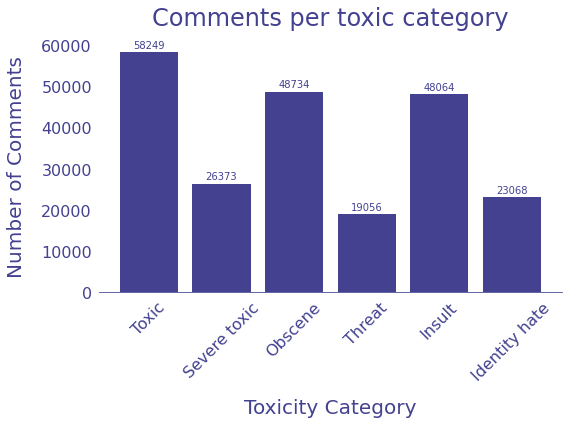

In [26]:
# pres_color = "#00ffcd"
pres_color = "#434190"

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.bar(
        x = np.arange(len(count)),
        height = count,
        color = pres_color,
        tick_label = toxic_class_labels )

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(pres_color)  
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)

ax.grid(False)


# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 1000,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=pres_color
     )

ax.set_xlabel('Toxicity Category', labelpad=15, color=pres_color, fontsize = 20)
ax.set_ylabel('Number of Comments', labelpad=15, color=pres_color, fontsize = 20)
ax.set_title('Comments per toxic category', pad=15, color=pres_color, fontsize = 24)

ax.tick_params(axis='x', colors=pres_color, labelsize=16, rotation=45)
ax.tick_params(axis='y', colors=pres_color, labelsize=16)


fig.tight_layout()

fig.savefig('../resources/images/002_augmented_toxicity_classification.png',bbox_inches='tight', transparent=True, dpi=200)